In [51]:
%alias_magic t timeit
%matplotlib inline
import json,io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os,sys
from scipy import stats
from twitter_analytics_api import *
from datetime import datetime as dt
# Import unquote to prevent url encoding errors in next_results
from urllib import unquote
sys.path.append(os.getcwd()) #sys.argv[0]

# pandas settings 
pd.set_option('expand_frame_repr', False)
pd.options.display.max_columns = 15
pd.options.display.max_rows = 25
pd.set_option('max_colwidth', 30)
pd.set_option('colheader_justify', 'center')
dfm = pd.DataFrame

timer = lambda: '%s_%s_%s'%dt.utctimetuple(dt.now())[3:6]
file_ext = lambda x: dict(to_json='.json',to_csv='.csv',to_excel='.xlsx').get(x,'')

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [52]:
%%timeit
tweets = ((status['text'], status['entities']['user_mentions'], status['entities']['hashtags'],
           status['retweet_count'], status.get('retweeted_status'))
                    for status in statuses)
tweets = [
            ( 
                pproc(texts.split()),
                pproc([i['screen_name'] for i in user_mentions]),
                pproc([i['text'] for i in hashtags]),
                retweet_count,
                
                pproc([retweeted_status['user']['screen_name']]) if retweeted_status else np.nan
            )
                for texts,user_mentions, hashtags, retweet_count, retweeted_status in tweets
        ]
df = dfm(tweets,columns=['texts','screen_names','hashtags','retweet_counts','retweet_screen_names']).drop_duplicates()
# print df

NameError: global name 'statuses' is not defined

In [43]:
df1 = tweets_words['texts'].value_counts()
for k,v in tweets_words.items():
    v.value_counts().plot(kind='hist').set(ylabel="Number of items in bin", xlabel="Bins (number of times an item appeared)",title= k)
    plt.show()

In [38]:
from datetime import datetime as dt


def my_decorator(orgi_fn):
    fn_name = 'Executing %s' % orgi_fn.__name__

    def new_fn(*args, **kwargs):
        tic = dt.now()  # pre_process
        # original_function (encapsulated with try catch)
        try:
            org_result = orgi_fn(*args, **kwargs)
            org_result = 'and the ans is %s' % float(org_result)  # post process
        except Exception as exp:
            org_result = 'but exception found, "%s"' % exp
        exe_time = dt.now() - tic
        print '%s %s' % (exe_time, fn_name),
        return org_result

    return new_fn


@my_decorator
def add(x, y):
    _ = [_ for _ in range(1000000)]  # delay use time.sleep()
    return x + y


@my_decorator
def mul(x, y):
    _ = [_ for _ in range(1000000)]  # delay
    return x * y


print add(5, 6)  # always return in float format
print mul(5, 6)  # always return in float format
print add('5', 6)  # always return in float format
print add('5', '6')  # always return in float format

In [ ]:
%%timeit
df = statuses_df
df['text']= df.text.apply(lambda x: pproc(x.split()))
entities = dfm.from_records(df.entities)
hashtags = entities.hashtags.apply(lambda x: pproc([x['text'] for x in x]))
screen_name = entities.user_mentions.apply(lambda x: pproc([x['screen_name'] for x in x]))
retweet_screen_name = df.retweeted_status.dropna().apply(lambda x: pproc(x['user']['screen_name'].split()))
p = ['retweet_count', 'text']
df = pd.concat([df[['text','retweet_count']], hashtags, screen_name,retweet_screen_name],axis=1)
df.columns = ['texts','retweet_counts','hashtags','screen_names','retweet_screen_names'] 
df = df[['texts', 'screen_names', 'hashtags', 'retweet_counts', 'retweet_screen_names']].drop_duplicates()

##############################################################################################################################################

%%timeit
df = statuses_df
def z(col):
    nRow = pd.Series()
    if col.name == 'text':
        return col.apply(lambda x: pproc(x.split()))
    elif col.name == 'entities':
        entities = dfm.from_records(col)
        nRow['hashtags'] = entities.hashtags.apply(lambda x: pproc([x['text'] for x in x]))
        nRow['screen_name'] = entities.user_mentions.apply(lambda x: pproc([x['screen_name'] for x in x]))
        return nRow
    elif col.name == 'retweeted_status':
        return col.dropna().apply(lambda x: pproc(x['user']['screen_name'].split()))
    # print nRow.texts
    
df = df[['text','retweeted_status']].apply(z) #  ,'entities','retweeted_status'
# print df

############################################################################################################################################


# %%timeit
# Dead slow approch
df = statuses_df
def z(row):
    nRow = pd.Series()
    nRow['texts'] = pproc(row['text'].split(' '))
    nRow['screen_names'] = pproc([val['screen_name'] for val in row['entities']['user_mentions']])
    nRow['hashtags'] = pproc([val['text'] for val in row['entities']['hashtags']])
    nRow['retweet_counts'] = row['retweet_count']
    nRow['retweet_screen_names'] = np.nan if pd.isnull(row['retweeted_status']) else pproc(row['retweeted_status']['user']['screen_name'].split())
    return nRow
df = df.apply(z,axis=1)



############################################################################################################################################

# %%timeit
# classic way for decoding tweet
pproc = lambda x: ',,,'.join(x).lower()
real = []
for status in statuses:
    temp = {}
    temp['texts'] = pproc(status['text'].split())
    temp['screen_names'] = []
    temp['hashtags'] = []
    temp['retweet_counts'] = status['retweet_count']
    retweeted_status = status.get('retweeted_status')
    if retweeted_status:
        temp['retweet_screen_name'] = pproc([retweeted_status['user']['screen_name']])
    
    for user_mention in status['entities']['user_mentions']:
        temp['screen_names'].append(user_mention['screen_name'] )
    for hashtag in status['entities']['hashtags']:
        temp['hashtags'].append( hashtag['text'] )
    temp['hashtags'] = pproc(temp['hashtags'])
    temp['screen_names'] = pproc(temp['screen_names'])
    
    real.append(temp)
a = dfm(real,columns=['texts','screen_names','hashtags','retweet_counts','retweet_screen_name']).drop_duplicates()
# print a

[-1.37607733 -0.9852388   1.55521165 -2.35317365 -0.30127137 -0.30127137
  0.77353459  0.67582496  0.87124422  0.1872768  -0.00814247  0.87124422
 -1.66920622 -0.88752916 -0.1058521   0.1872768   0.77353459 -0.20356173
 -0.00814247  1.26208276 -1.08294843  0.77353459 -0.49669063 -0.6921099
  0.28498643 -0.6921099  -1.27836769  1.06666349 -0.88752916 -0.398981
  0.77353459  1.84834055  0.28498643  0.77353459 -1.66920622 -0.88752916
 -2.64630255 -0.00814247  0.96895386  0.48040569  1.26208276 -0.30127137
 -1.27836769  1.75063092 -0.88752916  0.67582496  0.77353459  1.16437312
 -0.1058521   0.87124422  1.65292129  0.67582496  0.08956716 -0.9852388
 -0.88752916 -0.398981   -0.1058521  -0.30127137 -0.398981    1.26208276]
0.0911019282654
0.841621233573


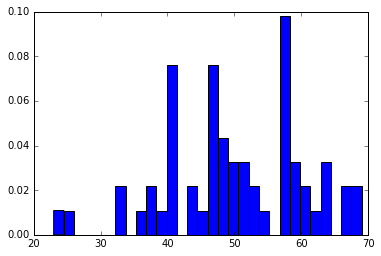

In [67]:
classscore = np.random.normal(50, 10, 60).round()
classscore = [36.0, 40.0, 66.0, 26.0, 47.0, 47.0, 58.0, 57.0, 59.0, 52.0, 50.0, 59.0, 33.0, 41.0, 49.0, 52.0, 58.0, 48.0, 50.0, 63.0, 39.0, 58.0, 45.0, 43.0, 53.0, 43.0, 37.0, 61.0, 41.0, 46.0, 58.0, 69.0, 53.0, 58.0, 33.0, 41.0, 23.0, 50.0, 60.0, 55.0, 63.0, 47.0, 37.0, 68.0, 41.0, 57.0, 58.0, 62.0, 49.0, 59.0, 67.0, 57.0, 51.0, 40.0, 41.0, 46.0, 49.0, 47.0, 46.0, 63.0]
plt.hist(classscore, 30, normed=True) #Number of breaks is 30
print stats.zscore(classscore)
print 1 - stats.norm.cdf(1.334)
print stats.norm.ppf(0.80)

        0   
0  -1.376077
1  -0.985239
2   1.555212
3  -2.353174
4  -0.301271
5  -0.301271
6   0.773535
7   0.675825
8   0.871244
9   0.187277
10 -0.008142
11  0.871244
..       ...
48 -0.105852
49  0.871244
50  1.652921
51  0.675825
52  0.089567
53 -0.985239
54 -0.887529
55 -0.398981
56 -0.105852
57 -0.301271
58 -0.398981
59  1.262083

[60 rows x 1 columns]
0.0911019282654
0.841621233573


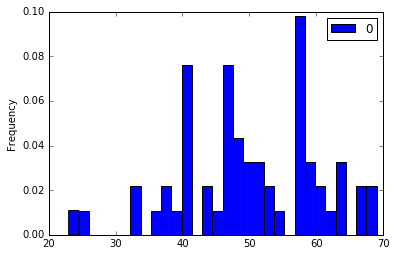

In [68]:
classscore = [36.0, 40.0, 66.0, 26.0, 47.0, 47.0, 58.0, 57.0, 59.0, 52.0, 50.0, 59.0, 33.0, 41.0, 49.0, 52.0, 58.0, 48.0, 50.0, 63.0, 39.0, 58.0, 45.0, 43.0, 53.0, 43.0, 37.0, 61.0, 41.0, 46.0, 58.0, 69.0, 53.0, 58.0, 33.0, 41.0, 23.0, 50.0, 60.0, 55.0, 63.0, 47.0, 37.0, 68.0, 41.0, 57.0, 58.0, 62.0, 49.0, 59.0, 67.0, 57.0, 51.0, 40.0, 41.0, 46.0, 49.0, 47.0, 46.0, 63.0]
classscore = dfm(classscore)
classscore.plot.hist(bins=30, normed=True) #Number of breaks is 30
print classscore.apply(stats.zscore)
print 1 - stats.norm.cdf(1.334)
print stats.norm.ppf(0.80)

In [40]:
(0.84 * classscore.std()) + classscore.mean()

In [42]:
zscore = ( 68 - classscore.mean() ) / classscore.std()
zscore

In [44]:
prob = 1 - stats.norm.cdf(zscore)
prob

In [46]:
zscore = ( 53 - 60 ) / 3.0
zscore